# Denoising timeseries data with WaveletBuffer


In [1]:
from wavelet_buffer import WaveletBuffer, denoise
import numpy as np
import matplotlib.pyplot as plt

blob = b""
with open("buffer_signal.bin", "rb") as f:
    blob = f.read()

print("initiale size ", len(blob)/ 1024)
buffer = WaveletBuffer.parse(blob)
print(buffer)

initiale size  190.349609375
WaveletBuffer<signal_number=1, signal_shape=(48199), decomposition_steps=9, wavelet_type=WaveletType.DB3>


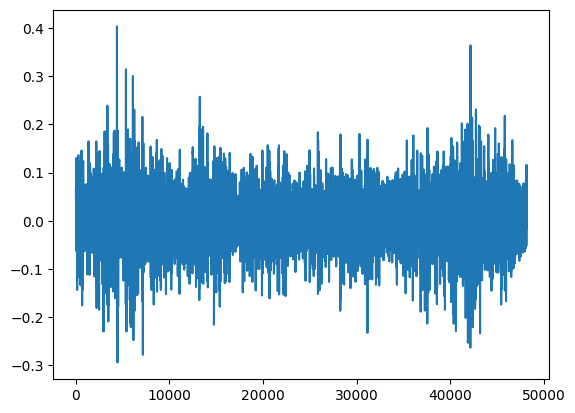

In [2]:
signal = buffer.compose()

plt.plot(signal)
plt.show()

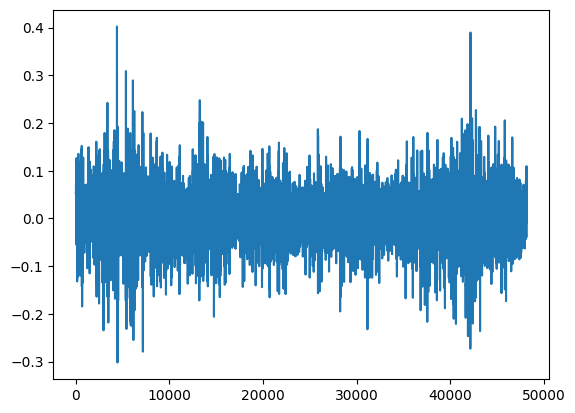

In [3]:
buffer.decompose(signal, denoise.Threshold(0, 0.04))
denoised = buffer.compose()
plt.plot(denoised)
plt.show()

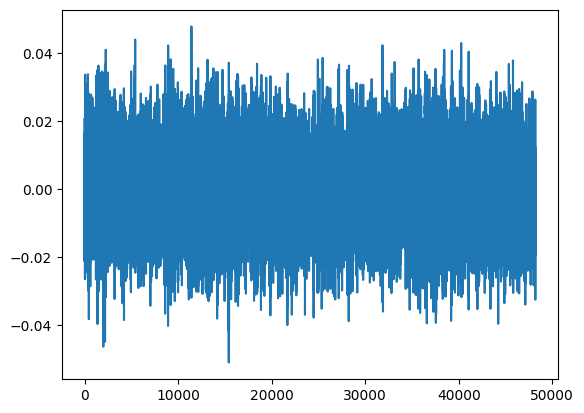

In [4]:
err = denoised - signal
plt.plot(err)
plt.show()

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(len(result)/2):]

def test(corr: np.ndarray):
    threshold = 1.96 / np.sqrt(len(corr))
    tests = np.where(np.abs(corr) <=threshold, 1, 0)
    print((tests.sum() / len(corr)) )
    return (tests.sum() / len(corr)) >= 0.95


cor = autocorr(err)
print(test(cor))

0.1730741301686757
False


In [6]:
result = 0
for x in range(1000):
    thr = 0.001*x
    print(thr)
    buffer.decompose(signal, denoise.Threshold(0, thr))
    err = buffer.compose() - signal
    corr = autocorr(err)
    if not test(corr):
        result = x
        break



0.0
1.0
0.001
1.0
0.002
0.9999792526815909
0.003
0.9999585053631818
0.004
0.9986514243034088
0.005
0.9768667399738584
0.006
0.9280482997572563


Compression size:  34.416015625


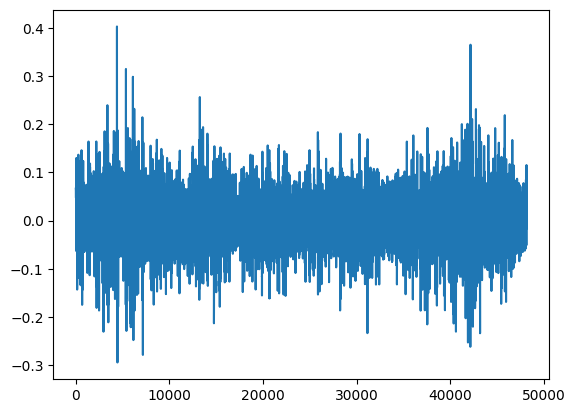

In [7]:
print("Compression size: ", len(buffer.serialize(compression_level=16)) / 1024)

signal = buffer.compose()

plt.plot(signal)
plt.show()

Compression (onlynoise) size:  0.37890625


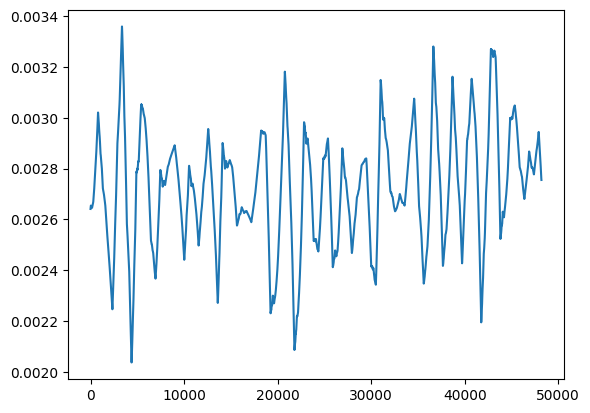

In [9]:
blob = b""
with open("buffer_no_signal.bin", "rb") as f:
    blob = f.read()

buffer = WaveletBuffer.parse(blob)
signal = buffer.compose()
buffer.decompose(buffer.compose(), denoise.Threshold(0, result))
print("Compression (onlynoise) size: ", len(buffer.serialize(compression_level=16)) / 1024)

plt.plot(signal)
plt.show()